You are tasked to perform image classification to classify concretes with or without cracks.

1. Link to the dataset: https://data.mendeley.com/datasets/5y9wdsg2zt/2
2. For criteria, try to achieve training and validation accuracy of more that 90%.
3. Make sure your model is not overfitting.
4. You may apply transfer learning.
5. Make sure you have a presentable README file.
6. Tips: You might want to use the model to make some predictions.
7. For Google Golab users. here is a guide on how to deal with files.
https://neptune.ai/blog/google-colab-dealing-with-files


In [ ]:
#1. Import packages
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers,optimizers,losses,callbacks,applications
import numpy as np
import os, datetime, pathlib
import matplotlib.pyplot as plt

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In [ ]:
!unzip -u "/content/gdrive/MyDrive/roadcrack.zip" -d /content/gdrive/MyDrive/roadcrack

Streaming output truncated to the last 5000 lines.
  inflating: /content/gdrive/MyDrive/roadcrack/road crack/Positive/15001_1.jpg  
  inflating: /content/gdrive/MyDrive/roadcrack/road crack/Positive/15002_1.jpg  
  inflating: /content/gdrive/MyDrive/roadcrack/road crack/Positive/15003_1.jpg  
  inflating: /content/gdrive/MyDrive/roadcrack/road crack/Positive/15004_1.jpg  
  inflating: /content/gdrive/MyDrive/roadcrack/road crack/Positive/15005_1.jpg  
  inflating: /content/gdrive/MyDrive/roadcrack/road crack/Positive/15006_1.jpg  
  inflating: /content/gdrive/MyDrive/roadcrack/road crack/Positive/15007_1.jpg  
  inflating: /content/gdrive/MyDrive/roadcrack/road crack/Positive/15008_1.jpg  
  inflating: /content/gdrive/MyDrive/roadcrack/road crack/Positive/15009_1.jpg  
  inflating: /content/gdrive/MyDrive/roadcrack/road crack/Positive/15010_1.jpg  
  inflating: /content/gdrive/MyDrive/roadcrack/road crack/Positive/15011_1.jpg  
  inflating: /content/gdrive/MyDrive/roadcrack/road crack/

In [ ]:
#2. Data preparation
file_path = r"/content/gdrive/MyDrive/roadcrack/road crack"
data_dir = pathlib.Path(file_path)

SEED = 12345
IMG_SIZE = (120,120)
BATCH_SIZE = 16

train_dataset = keras.utils.image_dataset_from_directory(data_dir,validation_split=0.2,subset='training',seed=SEED,shuffle=True,
                                                         image_size=IMG_SIZE,batch_size=BATCH_SIZE)
val_dataset = keras.utils.image_dataset_from_directory(data_dir,validation_split=0.2,subset='validation',seed=SEED,shuffle=True,
                                                         image_size=IMG_SIZE,batch_size=BATCH_SIZE)

Found 40000 files belonging to 2 classes.
Using 32000 files for training.
Found 40000 files belonging to 2 classes.
Using 8000 files for validation.


In [ ]:
#Further split validation into validation-test splits
val_batches = tf.data.experimental.cardinality(val_dataset)
test_dataset = val_dataset.take(val_batches//5)
validation_dataset = val_dataset.skip(val_batches//5)


#Create prefetch dataset for all the 3 splits
AUTOTUNE = tf.data.AUTOTUNE
pf_train = train_dataset.prefetch(buffer_size=AUTOTUNE)
pf_val = validation_dataset.prefetch(buffer_size=AUTOTUNE)
pf_test = test_dataset.prefetch(buffer_size=AUTOTUNE)

In [ ]:
# Let's start to work on the model
# Our model will be:
# Data augmentation --> Preprocessing --> Feature extraction (pretrained model) --> Classification

#3. Data augmentation layers
data_augmentation = keras.Sequential()
data_augmentation.add(layers.RandomFlip('horizontal_and_vertical'))
data_augmentation.add(layers.RandomRotation(0.25))


In [ ]:
#4. Creating Feature Extraction layers
#Create the layer for input preprocessing
preprocess_input = applications.mobilenet_v3.preprocess_input
# Create the base model by using VGG16
IMG_SHAPE = IMG_SIZE + (3,)
base_model = applications.MobileNetV3Small(input_shape=IMG_SHAPE,include_top=False,weights='imagenet')
#Freeze the layers in base model
base_model.trainable = False
base_model.summary()

4349952/4334752 [==============================] - 0s 0us/step
Model: "MobilenetV3small"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 120, 120, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling (Rescaling)          (None, 120, 120, 3)  0           ['input_1[0][0]']                
                                                                                                  
 Conv (Conv2D)                  (None, 60, 60, 16)   432         ['rescaling[0][0]']              
                                                                                                  
 Conv/BatchNorm (Bat

In [ ]:
#5. Create classification layers
class_names = train_dataset.class_names
nClass = len(class_names)

global_avg = layers.GlobalAveragePooling2D()
h1 = layers.Dense(128, activation="relu")
h2 = layers.Dense(64, activation="relu")
h3 = layers.Dense(32, activation="relu")
h4 = layers.Dense(16, activation="relu")
output_layer = layers.Dense(nClass,activation='softmax')

In [ ]:
#6. Create the entire model with Functional API
base_model.trainable = False
inputs = keras.Input(shape=IMG_SHAPE)
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x)
x = global_avg(x)
# x = layers.Dropout(0.2)(x)
x = h1(x)
x = h2(x)
x = h3(x)
x = h4(x)
outputs = output_layer(x)

model = keras.Model(inputs=inputs,outputs=outputs)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 120, 120, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 120, 120, 3)       0         
                                                                 
 MobilenetV3small (Functiona  (None, 4, 4, 576)        939120    
 l)                                                              
                                                                 
 global_average_pooling2d (G  (None, 576)              0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 128)               73856     
                                                                 
 dense_1 (Dense)             (None, 64)                8256  

In [ ]:
#7. Compile the model
lr_schedule = optimizers.schedules.CosineDecay(0.0001, 500)
optimizer = optimizers.Adam(learning_rate = lr_schedule)
loss = losses.SparseCategoricalCrossentropy()

model.compile(optimizer=optimizer,loss=loss,metrics=['accuracy'])

In [ ]:
from tensorflow.keras.callbacks import TensorBoard
#TensorBoard callback
log_path = os.path.join('Project_4', datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tb = TensorBoard(log_path, histogram_freq=1)

In [82]:
#8. Perform model training
EPOCHS = 1
history = model.fit(pf_train,validation_data=pf_val,epochs=EPOCHS)

2000/2000 [==============================] - 240s 120ms/step - loss: 0.0104 - accuracy: 0.9970 - val_loss: 0.0078 - val_accuracy: 0.9972


In [42]:
#Recompile the model
lr_schedule = optimizers.schedules.CosineDecay(0.00001, 500)
optimizer = optimizers.RMSprop(learning_rate=lr_schedule)
model.compile(optimizer=optimizer,loss=loss,metrics=['accuracy'])

In [49]:
base_model.trainable = True

for layer in base_model.layers[:120]:
    layer.trainable = False

#Follow up from the previous model training
history_fine_2 = model.fit(pf_train,validation_data=pf_val,epochs=1)

2000/2000 [==============================] - 242s 121ms/step - loss: 0.0120 - accuracy: 0.9970 - val_loss: 0.0078 - val_accuracy: 0.9972


In [50]:
base_model.trainable = False
output_layer.trainable = True
model.summary()

#Follow up from the previous model training
history_fine_3 = model.fit(pf_train,validation_data=pf_val,epochs=1)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 120, 120, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 120, 120, 3)       0         
                                                                 
 MobilenetV3small (Functiona  (None, 4, 4, 576)        939120    
 l)                                                              
                                                                 
 global_average_pooling2d (G  (None, 576)              0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 128)               73856     
                                                                 
 dense_1 (Dense)             (None, 64)                8256  

In [51]:
#Evaluate the model after training
test_loss, test_accuracy = model.evaluate(pf_test)

print("------------------------------After Training---------------------------")
print("Loss = ", test_loss)
print("Accuracy = ",test_accuracy)

100/100 [==============================] - 9s 83ms/step - loss: 0.0075 - accuracy: 0.9969
------------------------------After Training---------------------------
Loss =  0.00749098788946867
Accuracy =  0.996874988079071


In [52]:
#Deploy the model to make predictions
image_batch, label_batch = pf_test.as_numpy_iterator().next()
predictions = np.argmax(model.predict(image_batch),axis=1)

In [53]:
#Compare label vs prediction
label_vs_prediction = np.transpose(np.vstack((label_batch,predictions)))

In [54]:
print(label_vs_prediction)

[[1 1]
 [1 1]
 [1 1]
 [0 0]
 [1 1]
 [0 0]
 [1 1]
 [0 0]
 [0 0]
 [1 1]
 [1 1]
 [1 1]
 [1 1]
 [1 1]
 [0 0]
 [0 0]]


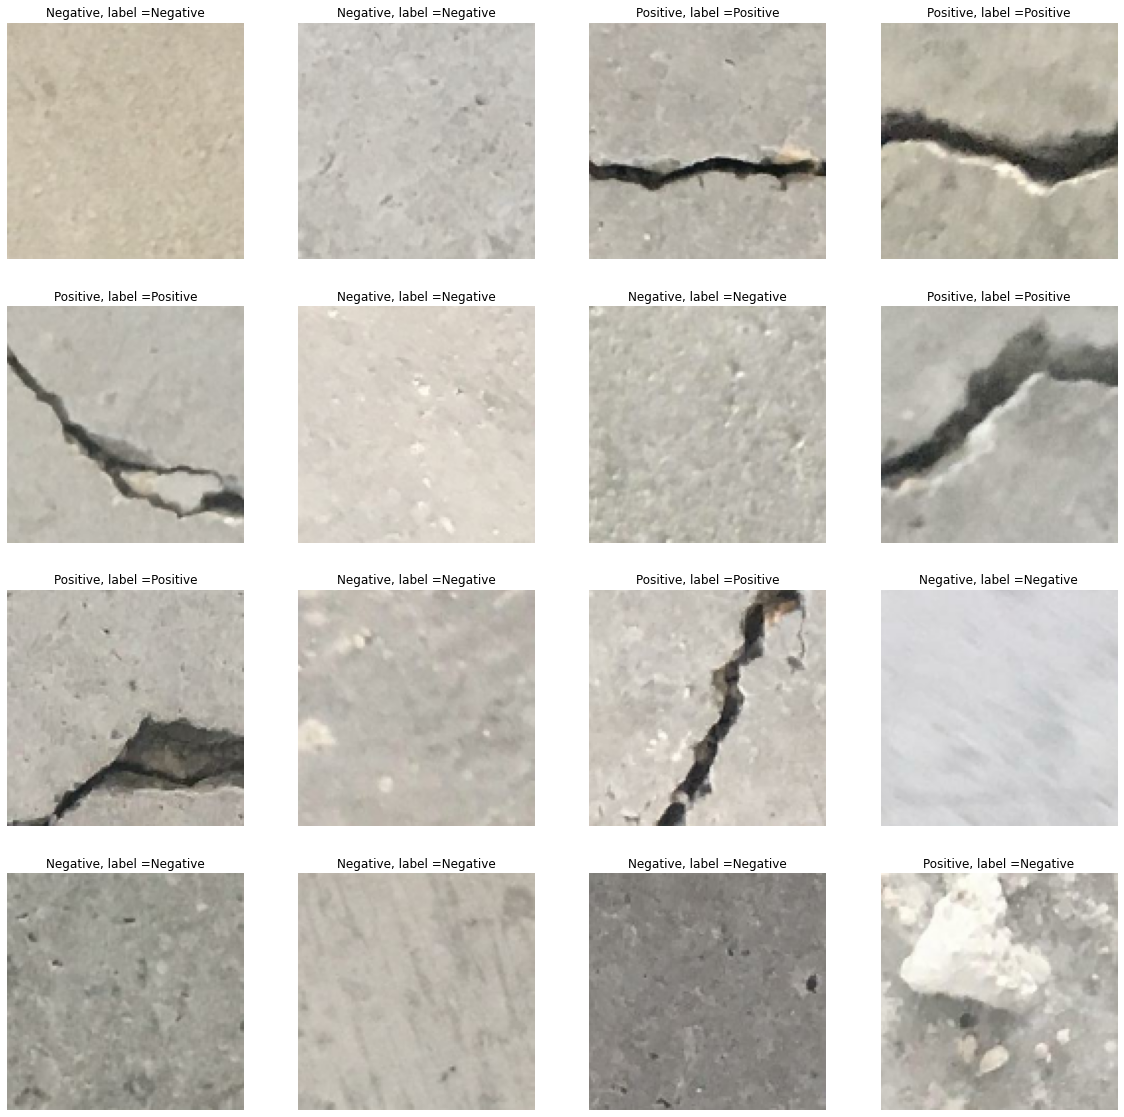

In [80]:
# Somesample of the images
import matplotlib.pyplot as plt
plt.figure(figsize=(20, 20))
class_names = train_dataset.class_names
for images, labels in test_dataset.take(1):
  for i in range(16):
    plt.subplot(4, 4, i+1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(str(class_names[np.argmax(model.predict(images),axis=1)[i]])+", label ="+str(class_names[labels[i]]))
    plt.savefig('concrete_crack.png')
    plt.axis("off")

In [ ]:
# As we can see from above.
# (i) Transfer learning bring us a huge advantage.
# (ii) Training by using Fragmented Data is not always useful, but sometimes it can improve the model significantly.

In [81]:
model.save('Project_3.h5') 